# MADS-Deep Learning
---
## Portfolio Examination Part 1
#### Janosch Höfer, 938969

## Table of contents

- [Imports](#imports) <br>
- [1. Exercise](#task1) <br>
- [2. Exercise](#task2) <br>
- [3. Exercise](#task3) <br>
- [4. Exercise](#task4) <br>
-[References](#ref)<br>

<a id='imports'></a>
## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm

torch.set_default_dtype(torch.float)
torch.manual_seed(1)

<a id='task1'></a>
## Exercise 1
Given a perceptron with weights $(0.1, 0.4, 0.6, 0.7)$ and bias $0.2$, compute the output for the tensor $\begin{pmatrix}1 & 0 & 1 & 0\\0.1 & 0.2 & 0.1 & 0.2\end{pmatrix}$ of dimensions (dataset, features).

In [2]:
weights = torch.tensor([0.1, 0.4, 0.6, 0.7])
bias = torch.tensor(0.2)
vector = torch.tensor([[1, 0, 1, 0], [0.1, 0.2, 0.1, 0.2]])

In [3]:
def perceptron_predict(
    input_t: torch.Tensor, weights: torch.Tensor, bias: torch.Tensor
) -> torch.Tensor:
    return torch.matmul(input_t, weights) + bias

In [4]:
output_1 = perceptron_predict(vector, weights, bias)
output_1

tensor([0.9000, 0.4900])

The result of the perceptron is a tensor with dimensionality one: $T(dataset)$. The results are 0.9 and 0.49.

<a id='task2'></a>
## Exercise 2
The vacation platform JourneyAdvisor wants to apply deep learning in their recommender engine,
that recommends points of interest to users based on their user account properties and previously
visited places. The catalog of the platform contains $14,467$ points of interest. Users can check-in at
such places using their phones. The platform has $1,989,345$ users. When users register, they enter
their birthday, a payment method and their home address.<br>
### 1. Propose a list of features, suitable for the recommendation task. Explain your choice!

Suitable features could be:
* Age
* Number of visits
* Payment method (as embeddings)
* Home address (postal code)

<div style="text-align: justify">
Instead of using the birthday, we can calculate the age of the user. This has the advantage, that age is not only a continuous value. It also is a smaller number than the birthday. The number of visits is also a continuous value that should be used for recommendations. If a user visits types of places more often, we can recommend places that users with similar preferences have visited. The payment method could be an interesting feature. Someone who uses Apple Pay would probably prefer to visit places, that offer this payment method. Whether a place offers Apple Pay can be inferred from other users who have visited that place. The difficulty here is that the payment method is a categorical value. To make this feature usable by our neural network, it has to be transformed, either using One-Hot Encoding or Embeddings. The last feature is the home address, more precisely the zip code. Here we have the same problem, that the zip code is a categorical value. But fortunately, we have multiple solutions for that problem. The first approach uses continuous data that can be assigned to the various zip codes, e.g. average salary, crime-rate, house prices, etc. The second approach uses the latitude and longitude. In both approaches we can further fine tune the data, by changing the granularity of the zip code to look at districts, cities, or states.
    </div>

### 2. Describe a tensor to model the data for JourneyAdvisor. Describe its dimensionality.

$T\begin{matrix}( POI,&&    User,    &&& features)\end{matrix}$<br>
$T\begin{matrix}( 14,467,& 1,989,345, & 4)\end{matrix}$

The result is a 3 dimensional tensor which has the age, number of visits, payment method and home address for each combination of user and POI.

### 3. How many entries does the tensor have?

In [5]:
print(f"{14467 * 1989345 * 4:,d}")

115,119,416,460


With the above dimensionality the total entries are 115,119,416,460. That's 115 Billion entries. Each additional feature would increases the number of entries by ~28 Billion.

<a id='task3'></a>
## Exercise 3
Familiarize yourself with the SMOTE [[1]](#1) algorithm. In your own words, describe the use-case of the
SMOTE. Among others, address these points:
### 1. In which situations can it be useful (explain in general and provide three examples)?

Synthetic Minority Oversampling Technique (SMOTE) uses statistical techniques to increase the number of underrepresented labels. It is useful then working with imbalanced datasets that comprise mostly majority samples and very few minority samples. It can be used for:
- Anomaly detection. When trying to predict unusual behaviors, the training data is mostly compromised of imbalanced data. Most of the time the monitored system is working as expected and the number of "bad" data points is spare.
- Image recognition. Training image recognition algorithms requires augmented training data for more robust models. For example, the images can be rotated or flipped along some axis. SMOTE could be used to create new, synthetic images that are similar to each other, which can then be used for training.
- Advertisement. When trying to predict what kind of customer/visitor will respond to advertisement. The training data usually contains more users who did not click on the advertisement than users who did.

### 2. What is its fundamental idea?

<div style="text-align: justify">
SMOTE does not simply duplicate the underrepresented samples. It takes a sample and, through the use of neighboring samples, generates new instances. SMOTE finds the nearest k-neighbors using the k-Nearest Neighbors algorithm. The difference between the sample and a neighbor is calculated and multiplied with a random value between 0 and 1. This value is then added to the sample to generate a new, synthetic point. This is done N times, so that the number of minority samples equals the number of majority samples.
</div>
<div style="text-align: center">
    <img src="data/smote.png", width=600>
    <figcaption>How SMOTE creates new samples <a href=#2>[2]</a></figcaption>
</div>
    
### 3. How is SMOTE different from oversampling with replacement?

<div style="text-align: justify">
Oversampling with replacement takes random samples from the minority class and adds them again to the dataset. SMOTE creates new, synthetic training data with features that did not exist before. The benefit of SMOTE, as described in <a href=#1>[1]</a>, is that these synthetic samples improve the models detection of regions rather than specific points. SMOTE is a superior oversampling option.
</div>

<a id='task4'></a>
## Exercise 4
Create a Jupyter Notebook to solve the following machine learning task in Python, using PyTorch
(and other suitable libraries):
### 1. Load and arrange the dataset *portfolio_data_sose_2022.csv*. It has two features, feature_1 and feature_2, and a target variable target.

In [6]:
df = pd.read_csv("data/portfolio_data_sose_2022.csv")
print(
    f"Number of rows: \t{df.shape[0]} \n"
    f"Number of columns: \t{df.shape[1]}\n"
    f"Number of targets: \t{df['target'].nunique()}"
)

Number of rows: 	10000 
Number of columns: 	3
Number of targets: 	2


In [7]:
df.head()

,feature_1,feature_2,target
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


### 2. Describe the class distribution.

The classes are highly imbalanced. Out of the 10.000 entries target 0 accounts for 9.900. 

In [8]:
df["target"].value_counts()

0    9900
1     100
Name: target, dtype: int64

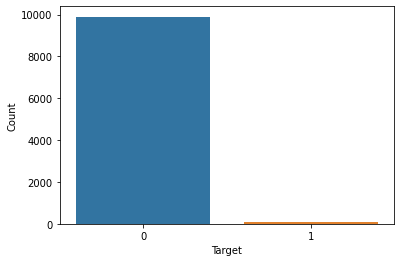

In [9]:
bar = sns.countplot(data=df, x="target")
bar.set(xlabel="Target", ylabel="Count")
plt.show()

### 3. Plot the data.

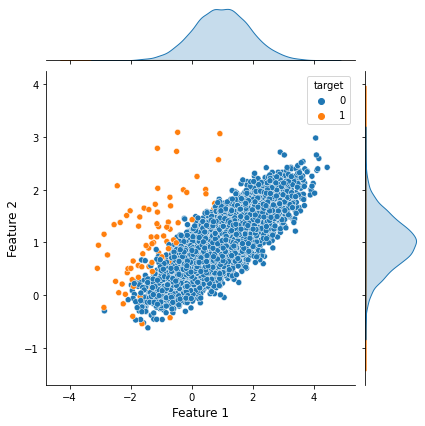

In [10]:
dis = sns.jointplot(data=df, x="feature_1", y="feature_2", hue="target", kind="scatter")
dis.set_axis_labels("Feature 1", "Feature 2", fontsize=12)
plt.show()

Plotting the data not only shows the imbalanced distribution of the two targets. Regarding feature 1 and 2, the data points of both targets can hardly be separated from each other. This could pose a problem for the classification at hand, because no more features are available for training.

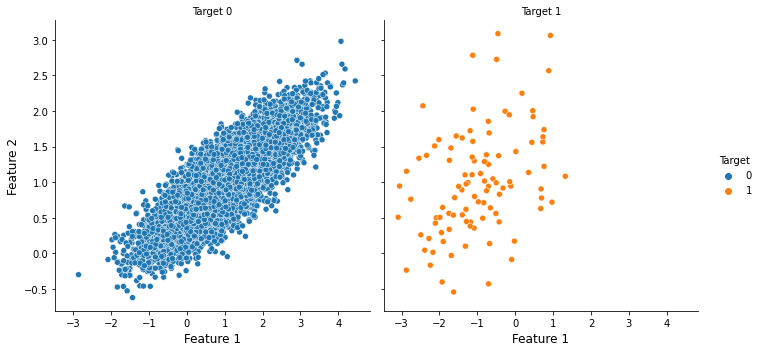

In [11]:
dis2 = sns.relplot(x="feature_1", y="feature_2", data=df, col="target", hue="target")
dis2.set_axis_labels("Feature 1", "Feature 2", fontsize=12)
dis2.set_titles(col_template="Target {col_name}")
dis2._legend.set_title("Target")
dis2.tight_layout()
plt.show()

### 4. Create a simple (single layer) neural network with two output neurons, one for each of the two classes 0 and 1 (i.e. use a multiclass classification setup).

In [12]:
class NNClassifier(nn.Module):
    def __init__(self, input_size: int, classes: int):
        super().__init__()
        self.lin1 = nn.Linear(input_size, classes)

    def forward(self, x: torch.Tensor):
        return self.lin1(x)

    def predict(self, x: torch.Tensor):
        _, indices = torch.max(self.forward(x), dim=1)
        return indices

<div style="text-align: justify">
The cross validation setting below trains 5 different models using the seeds 0 through 4. The averaged metrics for all 5 seeds are returned for further evaluation. To increase the performance of the neural network, the data is also scaled using the MinMaxScaler. The cross validation is not used to optimize the hyper-parameter and only returns a performance estimate. 
</div>

In [13]:
def cross_validation(
    model_class: nn.Module,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    lossfunc: nn.Module,
    lr: float,
    epochs: int,
) -> dict[dict]:

    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train_sc, dtype=torch.float)
    X_test_t = torch.tensor(X_test_sc, dtype=torch.float)
    y_train_t = torch.tensor(y_train.values, dtype=torch.long)
    y_test_t = torch.tensor(y_test.values, dtype=torch.long)

    results = dict()
    for seed in tqdm(range(5)):
        torch.manual_seed(seed)
        model, loss = train_model(model_class, X_train_t, y_train_t, lossfunc, lr, epochs)
        results[f"seed{seed}"] = compute_acc(model, X_test_t, y_test_t)

    results_avg = dict()
    for metric in ["Acc", "Bal_Acc", "Recall", "Precision"]:
        listy = [results[key][metric] for key in results.keys()]
        results_avg[f"Avg_{metric}"] = sum(listy) / len(listy)
    conf = [results[key]["conf_matrix"] for key in results.keys()]
    results_avg["avg_conf"] = np.mean(conf, axis=0)
    return results_avg


def train_model(
    model_class: nn.Module,
    x_data: torch.Tensor,
    y_data: torch.Tensor,
    lossfunc: nn.Module,
    lr: float,
    epochs: int,
) -> tuple[nn.Module, list]:

    model = model_class(2, 2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = [train_epoch(model, lossfunc, optimizer, x_data, y_data) for _ in range(epochs)]
    return model, loss


def train_epoch(model: nn.Module, lossfunc: nn.Module, optimizer, x_data, y_data):
    model.train()
    y_train_pred = model(x_data)
    optimizer.zero_grad()

    loss = lossfunc(y_train_pred, y_data)
    loss.backward()
    optimizer.step()
    return loss.item()

To evaluate the model the following metrics are used:
- Accuracy:
<div style="text-align: center">
    $\frac{TP + TN}{TP + TN + FP + FN}$
</div>
- Balanced Accuracy:
<div style="text-align: center">
    $\frac{1}{2} * (sensitivity + specificity)$ <br>
    with $sensitivity = \frac{TP}{TP + FN}$ <br>
    with $specificity = \frac{TN}{TN + FP}$
   </div>
    
- Recall:
<div style="text-align: center">
    $\frac{TP}{TP + FN}$
    </div>

- Precision:
<div style="text-align: center">
    $\frac{TP}{TP + FP}$
    </div>

- Confusion Matrix:
<div style="text-align: center">
    $\begin{pmatrix}TN & FP \\FN & TP \end{pmatrix}$ 
   </div>

In [14]:
def compute_acc(model: nn.Module, X: torch.Tensor, y: torch.Tensor) -> dict[str, float]:
    model.eval()
    with torch.no_grad():
        y_pred = model.predict(X)
    results = dict()
    results["Acc"] = metrics.accuracy_score(y, y_pred)
    results["Bal_Acc"] = metrics.balanced_accuracy_score(y, y_pred)
    results["Recall"] = metrics.recall_score(y, y_pred)
    results["Precision"] = metrics.precision_score(y, y_pred)
    results["conf_matrix"] = metrics.confusion_matrix(
        y, y_pred, labels=y.unique(), normalize="true"
    )
    return results

### 5. Compare the performance of the neural network in three different settings:

In [15]:
epochs = 5000
learning_rate = 0.1
folds = 5
loss_function = nn.CrossEntropyLoss()

data = df.iloc[:, :2]
labels = df["target"]

<div style="text-align: justify">
For the first setting the plain data is used. The data is split five times into training and test datasets and each training dataset is trained using the cross validation setup.<br>

<br>
DISCLAIMER: After a lot of discussion with my fellow students and Your feedback, I have concluded to use the setup below. Instead of an initial split into training and test data, the complete dataset is used for the five folds. This seems to be the most sensible approach with the instructions at hand because we are not optimizing hyper-parameters. Splitting into training data before the splits would result in two different sets of test data, the initial test dataset (1) and a test dataset (2) for each fold. Here, the cross validation would be used to optimize hyper-parameters using test data (2), which are then used to train a model which can be evaluated with the initial test dataset (1). This approach would result in one model for each setting instead of 25.
</div>

#### Plain Data

In [16]:
normal_results = dict()

splits = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
pbar = tqdm(total=folds)

for fold, (train_idx, test_idx) in enumerate(splits.split(data, labels)):
    X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]

    tqdm.write(f"Starting crossvalidation with fold {fold+1}")
    normal_results[f"fold{fold}"] = cross_validation(
        model_class=NNClassifier,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        lossfunc=loss_function,
        lr=learning_rate,
        epochs=epochs,
    )
    pbar.update()
pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 1


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 2


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 3


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 4


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 5


  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
metric_df = pd.DataFrame(normal_results).T.drop(columns="avg_conf")
metric_df

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
fold0,0.994,0.724747,0.45,0.9
fold1,0.996,0.8,0.6,1.0
fold2,0.994,0.749495,0.5,0.833333
fold3,0.995,0.799495,0.6,0.857143
fold4,0.994,0.724747,0.45,0.9


<div style="text-align: justify">
Using the plain data the average Accuracy for each folds spans between $0.994 - 0.996$, the average Balanced Accuracy between $0.72 - 0.80$, the average Recall between $0.45 - 0.60$ and average Precision between $0.84 - 1.0$.
</div>

In [18]:
metric_df_avg = pd.DataFrame(metric_df.mean(), columns=["Normal"]).T
metric_df_avg

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
Normal,0.9946,0.759697,0.52,0.898095


The average metrics across all folds are Accuracy: $0.995$, Balanced Accuracy: $0.76$, Recall: $0.52$ and Precision: $0.90$.

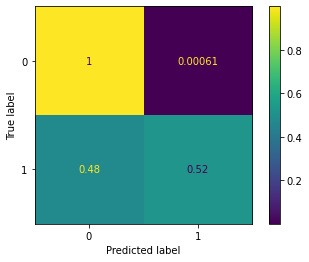

In [19]:
conf = [normal_results[key]["avg_conf"] for key in normal_results.keys()]
metrics.ConfusionMatrixDisplay(np.mean(conf, axis=0)).plot()
plt.show()

<div style="text-align: justify">
The confusion matrix above displays the percentage of correctly/wrongly predicted targets. Each row sums up to 100%. Target 0 has been wrongly predicted 0,061% times and target 1 has been wrongly predicted 48% times.
</div>

#### SMOTE

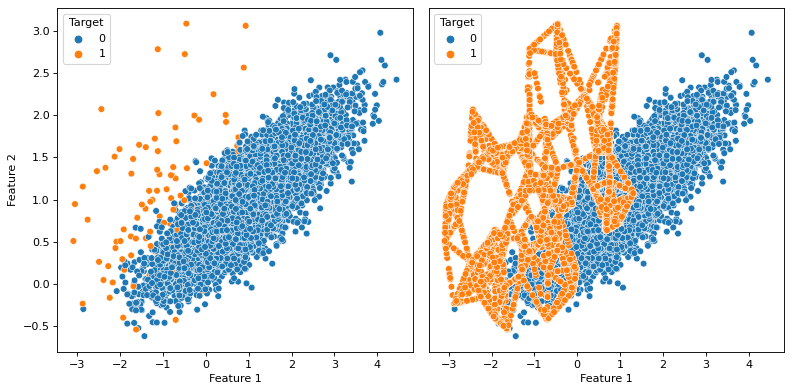

In [20]:
over_sm = SMOTE(sampling_strategy="not majority", random_state=1, n_jobs=-2)
data_res, labels_res = over_sm.fit_resample(data, labels)
df_res = data_res.assign(target=labels_res.values)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
for idx, df_sub in enumerate([df, df_res]):
    scat = sns.scatterplot(data=df_sub, x="feature_1", y="feature_2", hue="target", ax=axes[idx])
    scat.legend(title="Target")
    axes[idx].get_yaxis().set_visible(False) if idx else None
    axes[idx].set_xlabel("Feature 1")
    axes[idx].set_ylabel("Feature 2")
fig.tight_layout()
plt.show()

<div style="text-align: justify">
    The new distribution after using SMOTE shows how the new samples are synthesized. The new points are created between existing points. While the outermost points stay the outermost, the density of the already grouped points increases. The two targets appear to be more separable than before.
</div>

In [21]:
smote_results = dict()

splits = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
pbar = tqdm(total=folds)

for fold, (train_idx, test_idx) in enumerate(splits.split(data, labels)):
    X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]

    X_train_res, y_train_res = over_sm.fit_resample(X_train, y_train)

    tqdm.write(f"Starting crossvalidation with fold {fold+1}")
    smote_results[f"fold{fold}"] = cross_validation(
        model_class=NNClassifier,
        X_train=X_train_res,
        y_train=y_train_res,
        X_test=X_test,
        y_test=y_test,
        lossfunc=loss_function,
        lr=learning_rate,
        epochs=epochs,
    )
    pbar.update()
pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 1


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 2


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 3


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 4


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 5


  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
metric_df_smote = pd.DataFrame(smote_results).T.drop(columns="avg_conf")
metric_df_smote

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
fold0,0.926,0.937879,0.95,0.114458
fold1,0.932,0.891414,0.85,0.113346
fold2,0.9258,0.888283,0.85,0.104686
fold3,0.9255,0.888131,0.85,0.104294
fold4,0.9119,0.881263,0.85,0.08938


<div style="text-align: justify">
Using the plain data the average Accuracy for each folds spans between $0.912 - 0.932$, the average Balanced Accuracy between $0.88 - 0.94$, the average Recall between $0.85 - 0.95$ and average Precision between $0.089 - 0.114$.
</div>

In [23]:
metric_df_smote_avg = pd.DataFrame(metric_df_smote.mean(), columns=["Smote"]).T
metric_df_smote_avg

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
Smote,0.92424,0.897394,0.87,0.105233


The average metrics across all folds are Accuracy: $0.924$, Balanced Accuracy: $0.90$, Recall: $0.87$ and Precision: $0.11$.

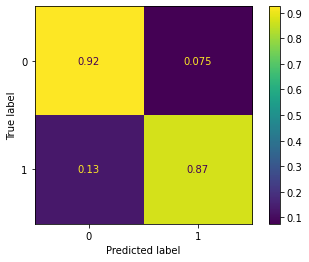

In [24]:
conf_sm = [smote_results[key]["avg_conf"] for key in smote_results.keys()]
metrics.ConfusionMatrixDisplay(np.mean(conf_sm, axis=0)).plot()
plt.show()

Target 0 has been wrongly predicted 7,5% times and target 1 has been wrongly predicted 13% times.

#### Using appropriate weights

<div style="text-align: justify">
    The weights are calculated using Scikit-learn's <i>compute_class_weight</i>-function using the following formula:
    $\frac{n_{samples}}{n_{classes} * np.bincount(y)}$ <a href=#3>[3]</a>.
</div>

In [25]:
w = len(df) / (len(labels.unique()) * np.bincount(labels))
w

array([ 0.50505051, 50.        ])

In [26]:
w = len(df) / (len(labels.unique()) * np.bincount(labels))
w[1] / w[0]

99.0

<div style="text-align: justify">
    The weights reflect the 99:1 distribution of the data points.
</div>

In [27]:
class_weights = compute_class_weight(class_weight="balanced", classes=labels.unique(), y=labels)
class_weights_t = torch.Tensor(class_weights)

loss_function_w = nn.CrossEntropyLoss(class_weights_t)

In [28]:
weight_results = dict()

splits = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
pbar = tqdm(total=folds)

for fold, (train_idx, test_idx) in enumerate(splits.split(data, labels)):
    X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]

    tqdm.write(f"Starting crossvalidation with fold {fold+1}")
    weight_results[f"fold{fold}"] = cross_validation(
        model_class=NNClassifier,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        lossfunc=loss_function_w,
        lr=learning_rate,
        epochs=epochs,
    )
    pbar.update()
pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 1


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 2


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 3


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 4


  0%|          | 0/5 [00:00<?, ?it/s]

Starting crossvalidation with fold 5


  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
metric_df_weight = pd.DataFrame(weight_results).T.drop(columns="avg_conf")
metric_df_weight

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
fold0,0.916,0.932828,0.95,0.102151
fold1,0.92,0.835859,0.75,0.088235
fold2,0.9214,0.910808,0.9,0.103927
fold3,0.9155,0.883081,0.85,0.092896
fold4,0.901,0.900505,0.9,0.084117


Using the plain data with appropriate weights the average Accuracy for each folds spans between $0.901 - 0.921$, the average Balanced Accuracy between $0.84 - 0.93$, the average Recall between $0.75 - 0.95$ and average Precision between $0.084 - 0.104$.

In [30]:
metric_df_weight_avg = pd.DataFrame(metric_df_weight.mean(), columns=["Weights"]).T
metric_df_weight_avg

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
Weights,0.91478,0.892616,0.87,0.094265


The average metrics across all folds are Accuracy: $0.915$, Balanced Accuracy: $0.89$, Recall: $0.87$ and Precision: $0.09$.

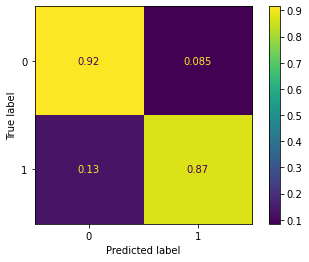

In [31]:
conf_w = [weight_results[key]["avg_conf"] for key in weight_results.keys()]
metrics.ConfusionMatrixDisplay(np.mean(conf_w, axis=0)).plot()
plt.show()

Target 0 has been wrongly predicted 8,5% times and target 1 has been wrongly predicted 13% times.

### 7. Interpret your results, explain your conclusions regarding SMOTE and class weights.

<div style="text-align: justify">
When comparing the different metrics, it is important to define what the task of the classifier is supposed to be. Which class is of interest? Is it acceptable to misclassify the other class, if the predictions for the target class can be improved? Should both classes be predicted equally good? Depending on the answer to these questions the same metrics can show different performance estimates for the classifiers. For this exercise I will assume that the minority class is what we are interested in. Hence the evaluation prefers a classifier which correctly predicts this class.<br>
Before comparing the results for the three different datasets, we must first establish a base line for the various metrics. The first two are the accuracy and balanced accuracy.<br>
Assuming that all points have been predicted as class 0, the base line for the accuracy is:
    <div style="text-align: center">
        $0.99 = \frac{0 + 9900}{10000}$<br>
    </div>
The base line for the balanced accuracy, assuming that all classes have been misclassified as class 0 equals:
    <div style="text-align: center">
        $0.5 = \frac{1}{2} * \left(\frac{0}{0+100} + \frac{9900}{9900+0}\right)$
       </div>
Because the dataset is so imbalanced a model that classifies everything as the majority class will already have an accuracy score of 0.99. We can observe this behavior in the first model, which only used the plain data. This model predicted almost all instances of class 0 as 0 and almost half of all instances of class 1 wrongly as class 0. The other two models, which more accurately predicted class 1, performed much worse in this metric. Hence the accuracy score alone is not a good metric for this dataset.<br>
</div>

In [32]:
pd.concat([metric_df_avg, metric_df_smote_avg, metric_df_weight_avg])

,Avg_Acc,Avg_Bal_Acc,Avg_Recall,Avg_Precision
Normal,0.99460,0.759697,0.52,0.898095
Smote,0.92424,0.897394,0.87,0.105233
Weights,0.91478,0.892616,0.87,0.094265


<div style="text-align: justify">
The balanced accuracy score is the mean of the sensitivity and specificity. Only correctly predicting class 0 would result in a score of 0.5. The other extreme, where only class 1 is correctly predicted, has also a score of 0.5. Getting a better value in this metric does not automatically mean that the model is getting better, it only shows whether both classes are predicted more accurately on average. The balanced accuracy for the two models using SMOTE and weights does increase, because the minority class is predicted more accurately. But at the same time class 0 is more often misclassified. Keeping our goal of detecting the minority class in mind, this increase in balanced accuracy is a good indicator. This becomes very clear then comparing the three confusion matrixes. Both, SMOTE and weights, predict the minority class 86% and 85% times correctly, while the plain data only predicts 52% correctly.
</div>

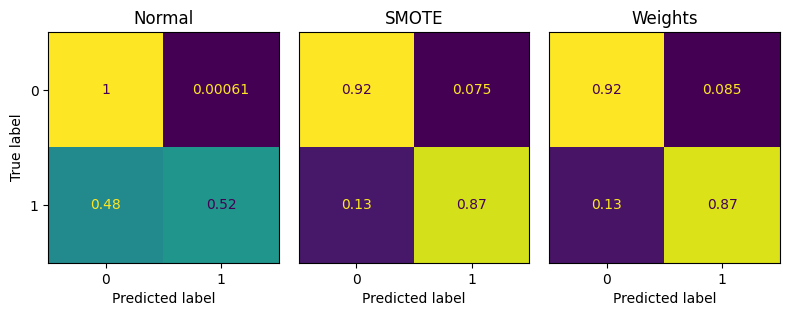

In [33]:
confmat = {"Normal": conf, "SMOTE": conf_sm, "Weights": conf_w}
fig, axes = plt.subplots(1, 3, figsize=(8, 6), dpi=100)
for i, (key, item) in enumerate(confmat.items()):
    metrics.ConfusionMatrixDisplay(np.mean(item, axis=0)).plot(ax=axes[i], colorbar=False)
    axes[i].set_title(key)
    axes[i].grid(False)
    if i:
        axes[i].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

<div style="text-align: justify">
    Although it was not asked, the other two metrics Recall and Precision present an interesting way to interpret the results. Recall is the percentage of correctly predicted minority classes. 
    <div style="text-align: center">
        $\frac{TP}{TP + FN}$
    </div>
This metric is very important for the above formulated task of classifying the minority class. It can also directly be read from the confusion matrix. Here again SMOTE and weights perform better, because they predict the minority class more often correctly. The last metric is Precision. Here the value decreases for SMOTE and weights. At first glance this suggests that their performance is worse. But taking into account how the Precision is calculated, a bad Precision score is not necessarily bad when working with imbalanced datasets. Even if 100% of the minority class are predicted correctly and only 1% of the majority class is predicted wrongly, the precision is $0.5 = \frac{100}{100+100}$. And because the last two models do predict the minority class much better at the cost of more wrong predictions of the majority class, the number of false positives increases more than number of true positives. And so the Precision decreases further and further. Therefore, this is not a good metric for imbalanced datasets.<br>
    So far both approaches, SMOTE and class weights, do perform significantly better on imbalanced datasets. The balanced accuracy and Recall not only improve significantly for both models, they are almost identical. And this despite approaching the problem of imbalance differently. And this seems plausible, because both basically move the focus from the majority to the minority class. The class weights punish misclassification of the minority class more and SMOTE increases the number of minority samples, which also means that those can no longer be misclassified as much as before. Both approaches are the right choice, if the focus lies on better predicting the minority class. At least for this dataset. Regarding the performance I would recommend using class weights, because those do not increase the number of samples and therefore the training time of the model.<br>
    Finally it can be said that than training neural networks (and ML models, classifiers, etc.) all preprocessing steps, methods that deal with imbalance, metrics and model setups always have to be evaluated for each dataset. Just because something did work the last time it must not have to work with the new data.
</div>

<a id='ref'></a>
## References
[1] <a id='1'>N. V. Chawla, K. W. Bowyer, L. O. Hall, and W. P. Kegelmeyer, “Smote: Synthetic minority
over-sampling technique,” Journal of Artificial Intelligence Research, vol. 16, pp. 321–357, 2002.</a><br>
[2] <a id='2'>Minoue-xx. Oversampling with SMOTE with its relative algorithms. https://github.com/minoue-xx/Oversampling-Imbalanced-Data</a><br>
[3] <a id='3'>Scikit-learn. Compute Class Weights. https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html</a>